In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms.v2 as tfs
from torchinfo import summary
from sklearn.model_selection import train_test_split

from torchvision.models import vit_b_32, ViT_B_32_Weights, swin_t, Swin_T_Weights

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from pytorch_memlab import MemReporter

import os
import warnings
from IPython.display import clear_output

warnings.filterwarnings('ignore')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# PATHS
PATH_TO_DATASET = './ProcessedDataset'

# IMAGES
IMAGE_WIDTH  = 224
IMAGE_HEIGHT = 224
REAL_LABEL   = 0
FAKE_LABEL   = 1

# IMAGE ENCODERS
EMBEDDING_SIZE       = 768
SWIN_EMBEDDING_SIZES = (96, 192, 384, 768)
YOLO_EMBEDDING_SIZES = (96, 192, 384, 768)
HID_STATE            = 1280
NUM_CLASSES          = 2   
BATCH_SIZE           = 32
DROPOUT              = 0.2
NUM_HEADS            = 8
NUM_FRAMES           = 30      # number of frames in each video
NUM_LEVELS           = 6

# TRAINING
RANDOM_SEED = 42
NUM_EPOCH   = 20
BASE_LR     = 5e-5
TRAIN_SIZE  = 0.8
VAL_SIZE    = 0.1
TEST_SIZE   = 1.0 - TRAIN_SIZE - VAL_SIZE

### Dataset

In [3]:
class DeepfakeDataset(data.Dataset):
    def __init__(self, path, deepfake_type, transform=None):
        super().__init__()

        self.path = path
        self.deepfake_type = deepfake_type
        self.transform = transform
        self.files = []
        self.targets = []
        self.len = 0

        # real videos
        path_to_real = os.path.join(self.path, 'original')
        real = os.listdir(path_to_real)
        self.files.extend(list(map(lambda x: os.path.join(path_to_real, x), real)))
        self.targets.extend([REAL_LABEL] * len(real))
        self.len += len(real)

        # fake videos
        path_to_fake = os.path.join(self.path, self.deepfake_type)
        fake = os.listdir(path_to_fake)
        self.files.extend(list(map(lambda x: os.path.join(path_to_fake, x), fake)))
        self.targets.extend([FAKE_LABEL] * len(fake))
        self.len += len(fake)

        self.targets = torch.tensor(self.targets)

    def __getitem__(self, index):
        video = self.files[index]
        t = self.targets[index].item()
        v = []

        frames = os.listdir(video)
        frames.sort(key=lambda x: int(x[6:-4])) #sorting frames since os.listdir has no order of elements

        for frame in frames:
            f = Image.open(os.path.join(video, frame))
            if (self.transform):
                f = self.transform(f)
            v.append(f)

        v = torch.stack(v)

        return v, t
    
    def __len__(self):
        return self.len

In [4]:
transforms = tfs.Compose([
    tfs.ToTensor(),
    tfs.Resize((IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=tfs.InterpolationMode.BICUBIC),
    tfs.ToDtype(torch.float32),
    tfs.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [5]:
deepfakes_dataset = DeepfakeDataset(PATH_TO_DATASET, 'Deepfakes', transform=transforms)
face2face_dataset = DeepfakeDataset(PATH_TO_DATASET, 'Face2Face', transform=transforms)
faceswap_dataset = DeepfakeDataset(PATH_TO_DATASET, 'FaceSwap', transform=transforms)

print(f'Deepfakes: {len(deepfakes_dataset)}')
print(f'Face2Face: {len(face2face_dataset)}')
print(f'FaceSwap: {len(faceswap_dataset)}')

Deepfakes: 1998
Face2Face: 1999
FaceSwap: 1999


### Dataloaders

In [6]:
def get_dataloaders(dataset):
    # get split indices 
    train_idx, temp_idx = train_test_split(
        np.arange(len(dataset.targets)),
        test_size=TEST_SIZE + VAL_SIZE,
        shuffle=True,
        stratify=dataset.targets,
        random_state=RANDOM_SEED
    )
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=TEST_SIZE / (TEST_SIZE + VAL_SIZE),
        stratify=dataset.targets[temp_idx],
        random_state=RANDOM_SEED
    )

    # make subsets
    train_dataset = data.Subset(dataset, train_idx)
    val_dataset = data.Subset(dataset, val_idx)
    test_dataset = data.Subset(dataset, test_idx)

    # make dataloaders
    train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader

In [7]:
deepfakes_train_dataloader, deepfakes_val_dataloader, deepfakes_test_dataloader = get_dataloaders(deepfakes_dataset)
face2face_train_dataloader, face2face_val_dataloader, face2face_test_dataloader = get_dataloaders(face2face_dataset)
faceswap_train_dataloader, faceswap_val_dataloader, faceswap_test_dataloader = get_dataloaders(faceswap_dataset)

### Train and test functions

In [8]:
def train_model(classifier_model, train_data, val_data, save=None):
    opt = torch.optim.AdamW(classifier_model.parameters(), BASE_LR)
    loss_func = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.2, patience=3, threshold=4e-3, min_lr=1e-7)
    
    val_loss_history = []
    accuracy_history = []
    train_loss_history = []

    for _e in range(NUM_EPOCH):
        # ----- training -----
        train_loss = 0
        classifier_model.train()
        for x_batch, y_batch in tqdm(train_data, desc=f'Epoch {_e + 1}/{NUM_EPOCH} training'):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # gradient descent
            opt.zero_grad()
            output = classifier_model(x_batch)
            loss = loss_func(output, y_batch)
            train_loss += loss.item() * len(y_batch)
            
            loss.backward()
            opt.step()
        
        # ----- validation -----
        correct = 0
        total = 0
        val_loss = 0.0
        classifier_model.eval()
        with torch.no_grad():
            for x_val, y_val in tqdm(val_data, desc=f'Validation'):
                x_val, y_val = x_val.to(device), y_val.to(device)

                output = classifier_model(x_val)
                correct += torch.sum(torch.argmax(output, dim=1) == y_val).item()
                total += len(y_val)
                val_loss += loss_func(output, y_val).item() * len(y_val)

        train_loss /= len(train_data.dataset)
        val_loss /= len(val_data.dataset)
        accuracy = correct / total

        val_loss_history.append(val_loss)
        accuracy_history.append(accuracy)
        train_loss_history.append(train_loss)

        # ----- monitoring -----
        clear_output()
        print('-------------------------------')
        print(f'Epoch {_e + 1} stats')
        print(f'Train loss: {train_loss:.4f}')
        print(f'Validation accuracy: {accuracy:.4f}')
        print(f'Validation loss: {val_loss:.4f}')
        print(f'Current learning rate: {scheduler.get_last_lr()[-1]}')
        print('-------------------------------')
        
        fig, ax = plt.subplots(2)
        fig.tight_layout()

        ax[0].plot(range(_e + 1), train_loss_history, label='Train loss')
        ax[0].set_title('Train metrics')
        ax[0].legend(loc='upper left')

        ax[1].plot(range(_e + 1), val_loss_history, label='Val loss')
        ax[1].plot(range(_e + 1), accuracy_history, label='Val accuracy')
        ax[1].set_title('Val metrics')
        ax[1].legend(loc='upper left')
        
        plt.show()

        # update scheduler
        scheduler.step(val_loss)
    
    # ----- saving -----
    if (save):
        torch.save(classifier_model.state_dict(), 'models/' + save + '.tar')

In [24]:
def get_model_metrics(classifier_model, test_data, mistakes, labels):
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    classifier_model.eval()
    with torch.no_grad():
        for x_test, y_test in tqdm(test_data, desc='Testing'):
            x_test, y_test = x_test.to(device), y_test.to(device)

            # get classification
            output = classifier_model(x_test)
            y_pred = torch.argmax(output, dim=1)

            for i, (pred, real) in enumerate(zip(y_pred, y_test)):
                if (pred == 1 and real == 1):
                    TP += 1
                elif (pred == 0 and real == 0):
                    TN += 1
                elif (pred == 1 and real == 0):
                    FP += 1
                    mistakes.append(x_test[i][0].cpu().detach())
                    labels.append((pred, real))
                elif (pred == 0 and real == 1):
                    FN += 1
                    mistakes.append(x_test[i][0].cpu().detach())
                    labels.append((pred, real))
                else:
                    raise f'Uncorrect labels; predicted: {pred}, real: {real}'

    return TP, TN, FP, FN

### ViT

In [6]:
class DeepfakeClassifier(nn.Module):
    def __init__(self, input_size=EMBEDDING_SIZE, hid_state=HID_STATE):
        super().__init__()

        # encoder
        self.backbone = vit_b_32(weights=ViT_B_32_Weights.IMAGENET1K_V1)
        self.backbone.eval()
        self.activations = {}

        # hooks
        self.backbone.encoder.layers[1].register_forward_hook(self.__get_activation('encoder_2nd_block'))
        self.backbone.encoder.layers[3].register_forward_hook(self.__get_activation('encoder_4th_block'))
        self.backbone.encoder.layers[5].register_forward_hook(self.__get_activation('encoder_6th_block'))
        self.backbone.encoder.layers[7].register_forward_hook(self.__get_activation('encoder_8th_block'))
        self.backbone.encoder.layers[9].register_forward_hook(self.__get_activation('encoder_10th_block'))
        self.backbone.encoder.layers[11].register_forward_hook(self.__get_activation('encoder_12th_block'))

        # rnn for each levels of hierarchy
        self.levels_rnn = nn.ModuleList([
            nn.GRU(input_size, hid_state, batch_first=True)
            for _ in range(NUM_LEVELS)
        ])

        # linear layer
        self.fc = nn.Linear(NUM_LEVELS * hid_state, NUM_CLASSES)
    
    def forward(self, x):
        self.activations = {}
        batch_size = x.shape[0]

        outputs = []
        for i in range(batch_size):
            # pass all frames to encoder
            with torch.no_grad():
                self.backbone(x[i])

            # get embeddings from different hidden states
            # embeddings.shape = [seq_len, num_hid_states, frames_hid_state]
            embeddings = torch.stack((
                self.activations['encoder_2nd_block'],
                self.activations['encoder_4th_block'],
                self.activations['encoder_6th_block'],
                self.activations['encoder_8th_block'],
                self.activations['encoder_10th_block'],
                self.activations['encoder_12th_block']
            ), dim=1)
            
            # rnn for each levels of hierarchy
            levels_output = []
            for j in range(len(self.levels_rnn)):
                out, _ = self.levels_rnn[j](embeddings[:, j, :])
                levels_output.append(out[-1])
            outputs.append(torch.stack(levels_output).flatten())
        
        # get logits
        # outputs.shape = [batch_size, NUM_LEVELS * hid_state]
        outputs = torch.stack(outputs)
        logits = self.fc(outputs)
            
        return logits

    def __get_activation(self, name):
        def hook(model, input, output):
            # getting only CLS tokens
            self.activations[name] = output[:, 0, :].detach()
        return hook

#### Deepfakes

In [ ]:
vit_deepfakes = DeepfakeClassifier().to(device)
if (os.path.exists('models/vit_deepfakes.tar')):
    vit_deepfakes.load_state_dict(torch.load('models/vit_deepfakes.tar', weights_only=True))
else:
    train_model(vit_deepfakes, deepfakes_train_dataloader, deepfakes_val_dataloader, 'vit_deepfakes')

In [ ]:
vit_deepfakes.eval()
mistakes = []  # first frames of videos that were misclassifed  
labels = []    # tuple for each frame: (predicted label, real label)
TP, TN, FP, FN = get_model_metrics(vit_deepfakes, deepfakes_test_dataloader)

print(f'True Positive:  {TP}')
print(f'True Negative:  {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print('-----------------------')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN) * 100}%')

Testing: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]

True Positive:  85
True Negative:  94
False Positive: 6
False Negative: 15
-----------------------
Accuracy: 89.5%


#### Face2Face

-------------------------------
Epoch 20 stats
Train loss: 0.3043
Validation accuracy: 0.7550
Validation loss: 0.4632
Current learning rate: 1e-05
-------------------------------


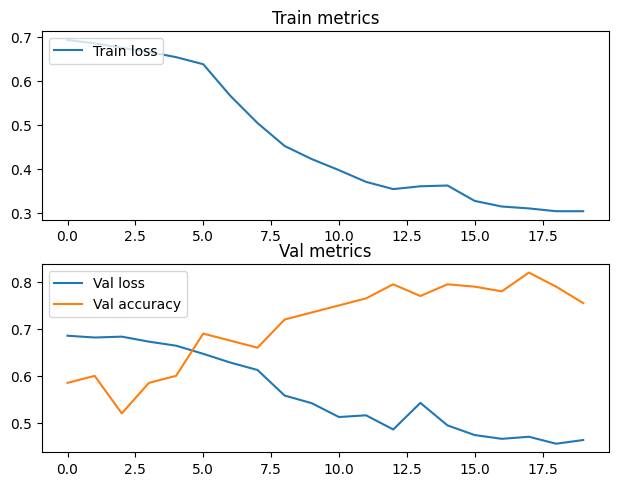

In [ ]:
vit_face2face = DeepfakeClassifier().to(device)
if (os.path.exists('models/vit_face2face.tar')):
    vit_face2face.load_state_dict(torch.load('models/vit_face2face.tar', weights_only=True))
else:
    train_model(vit_face2face, face2face_train_dataloader, face2face_val_dataloader, 'vit_face2face')

In [ ]:
vit_face2face.eval()
mistakes = []  # first frames of videos that were misclassifed  
labels = []    # tuple for each frame: (predicted label, real label)
TP, TN, FP, FN = get_model_metrics(vit_face2face, face2face_test_dataloader)

print(f'True Positive:  {TP}')
print(f'True Negative:  {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print('-----------------------')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN) * 100}%')

Testing: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]

True Positive:  87
True Negative:  78
False Positive: 22
False Negative: 13
-----------------------
Accuracy: 82.5%


#### FaceSwap

-------------------------------
Epoch 20 stats
Train loss: 0.0763
Validation accuracy: 0.8850
Validation loss: 0.3426
Current learning rate: 1e-05
-------------------------------


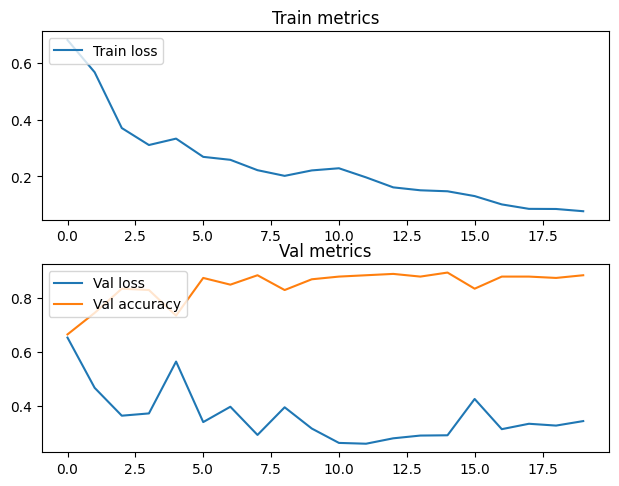

In [ ]:
vit_faceswap = DeepfakeClassifier().to(device)
if (os.path.exists('models/vit_faceswap.tar')):
    vit_faceswap.load_state_dict(torch.load('models/vit_faceswap.tar', weights_only=True))
else:
    train_model(vit_faceswap, faceswap_train_dataloader, faceswap_val_dataloader, 'vit_faceswap')

In [ ]:
vit_faceswap.eval()
mistakes = []  # first frames of videos that were misclassifed  
labels = []    # tuple for each frame: (predicted label, real label)
TP, TN, FP, FN = get_model_metrics(vit_faceswap, faceswap_test_dataloader)

print(f'True Positive:  {TP}')
print(f'True Negative:  {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print('-----------------------')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN) * 100}%')

Testing: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]

True Positive:  84
True Negative:  84
False Positive: 16
False Negative: 16
-----------------------
Accuracy: 84.0%


### Swin Transformer

In [10]:
class DeepfakeClassifierSwin(nn.Module):
    def __init__(self, input_size=SWIN_EMBEDDING_SIZES, hid_state=HID_STATE, finetuned=False):
        super().__init__()

        # encoder
        self.backbone = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)
        
        if (finetuned):
            self.backbone.head = nn.Linear(768, 20)  # definitly not a good way, but i'm too lazy
            self.backbone.load_state_dict(torch.load('models/ft_swin/ft_swin_t.tar', weights_only=True))
        
        self.backbone.eval()
        self.activations = {}

        # hooks
        self.backbone.features[1][1].register_forward_hook(self.__get_activation('swin_2nd_block'))
        self.backbone.features[3][1].register_forward_hook(self.__get_activation('swin_4th_block'))
        self.backbone.features[5][1].register_forward_hook(self.__get_activation('swin_6th_block'))
        self.backbone.features[5][3].register_forward_hook(self.__get_activation('swin_8th_block'))
        self.backbone.features[5][5].register_forward_hook(self.__get_activation('swin_10th_block'))
        self.backbone.features[7][1].register_forward_hook(self.__get_activation('swin_12th_block'))

        # rnn for each levels of hierarchy
        self.levels_rnn = nn.ModuleList([
            nn.GRU(input_size[0], hid_state, batch_first=True),
            nn.GRU(input_size[1], hid_state, batch_first=True),
            nn.GRU(input_size[2], hid_state, batch_first=True),
            nn.GRU(input_size[2], hid_state, batch_first=True),
            nn.GRU(input_size[2], hid_state, batch_first=True),
            nn.GRU(input_size[3], hid_state, batch_first=True)
        ])
        
        # linear layer
        self.fc = nn.Linear(NUM_LEVELS * hid_state, NUM_CLASSES)
    
    def forward(self, x):
        self.activations = {}
        batch_size = x.shape[0]

        outputs = []
        for i in range(batch_size):
            # pass all frames to encoder
            with torch.no_grad():
                self.backbone(x[i])

            # get embeddings from different hidden states
            # embeddings.shape = [seq_len, num_hid_states, frames_hid_state]
            embeddings = [
                self.activations['swin_2nd_block'],
                self.activations['swin_4th_block'],
                self.activations['swin_6th_block'],
                self.activations['swin_8th_block'],
                self.activations['swin_10th_block'],
                self.activations['swin_12th_block']
            ]
            
            # rnn for each levels of hierarchy
            levels_output = []
            for j in range(len(self.levels_rnn)):
                out, _ = self.levels_rnn[j](embeddings[j])
                levels_output.append(out[-1])
            outputs.append(torch.stack(levels_output).flatten())
        
        # get logits
        # outputs.shape = [batch_size, NUM_LEVELS * hid_state]
        outputs = torch.stack(outputs)
        logits = self.fc(outputs)
            
        return logits

    def __get_activation(self, name):
        def hook(model, input, output):
            # getting only CLS tokens
            self.activations[name] = F.adaptive_avg_pool2d(output.permute(0, 3, 1, 2), (1, 1)).squeeze()
        return hook

#### Deepfakes

In [11]:
swin_deepfakes = DeepfakeClassifierSwin().to(device)
if (os.path.exists('models/swin/swin_deepfakes.tar')):
    swin_deepfakes.load_state_dict(torch.load('models/swin/swin_deepfakes.tar', weights_only=True))
else:
    train_model(swin_deepfakes, deepfakes_train_dataloader, deepfakes_val_dataloader, 'swin/swin_deepfakes')

In [54]:
swin_deepfakes.eval()
mistakes = []  # first frames of videos that were misclassifed  
labels = []    # tuple for each frame: (predicted label, real label)
TP, TN, FP, FN = get_model_metrics(swin_deepfakes, deepfakes_test_dataloader, mistakes, labels)

print(f'True Positive:  {TP}')
print(f'True Negative:  {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print('-----------------------')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN) * 100}%')
print(f'Precision: {TP / (TP + FP)}')
print(f'Recall: {TP / (TP + FN)}')

Testing: 100%|██████████| 7/7 [00:22<00:00,  3.17s/it]

True Positive:  97
True Negative:  88
False Positive: 12
False Negative: 3
-----------------------
Accuracy: 92.5%
Precision: 0.8899082568807339
Recall: 0.97


In [30]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

mean = mean.view(1, 3, 1, 1)
std = std.view(1, 3, 1, 1)

mistakes = torch.stack(mistakes)
mistakes = mistakes * std + mean

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.023313075..1.0045065].


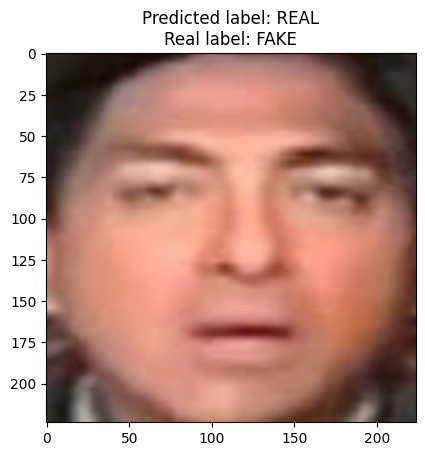

In [52]:
l = ('REAL', 'FAKE')

ind = 12
plt.imshow(mistakes[ind].permute(1, 2, 0).numpy())
pred = l[labels[ind][0].item()]
real = l[labels[ind][1].item()]
plt.title(f'Predicted label: {pred}\nReal label: {real}')
plt.show()

#### Face2Face

In [55]:
swin_face2face = DeepfakeClassifierSwin().to(device)
if (os.path.exists('models/swin/swin_face2face.tar')):
    swin_face2face.load_state_dict(torch.load('models/swin/swin_face2face.tar', weights_only=True))
else:
    train_model(swin_face2face, face2face_train_dataloader, face2face_val_dataloader, 'swin/swin_face2face')

In [57]:
swin_face2face.eval()
mistakes = []  # first frames of videos that were misclassifed  
labels = []    # tuple for each frame: (predicted label, real label)
TP, TN, FP, FN = get_model_metrics(swin_face2face, face2face_test_dataloader, mistakes, labels)

print(f'True Positive:  {TP}')
print(f'True Negative:  {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print('-----------------------')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN) * 100}%')
print(f'Precision: {TP / (TP + FP)}')
print(f'Recall: {TP / (TP + FN)}')

Testing: 100%|██████████| 7/7 [00:23<00:00,  3.29s/it]

True Positive:  92
True Negative:  85
False Positive: 15
False Negative: 8
-----------------------
Accuracy: 88.5%
Precision: 0.8598130841121495
Recall: 0.92


#### FaceSwap

In [58]:
swin_faceswap = DeepfakeClassifierSwin().to(device)
if (os.path.exists('models/swin/swin_faceswap.tar')):
    swin_faceswap.load_state_dict(torch.load('models/swin/swin_faceswap.tar', weights_only=True))
else:
    train_model(swin_faceswap, faceswap_train_dataloader, faceswap_val_dataloader, 'swin/swin_faceswap')

In [60]:
swin_faceswap.eval()
mistakes = []  # first frames of videos that were misclassifed  
labels = []    # tuple for each frame: (predicted label, real label)
TP, TN, FP, FN = get_model_metrics(swin_faceswap, faceswap_test_dataloader, mistakes, labels)

print(f'True Positive:  {TP}')
print(f'True Negative:  {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print('-----------------------')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN) * 100}%')
print(f'Precision: {TP / (TP + FP)}')
print(f'Recall: {TP / (TP + FN)}')

Testing: 100%|██████████| 7/7 [00:22<00:00,  3.23s/it]

True Positive:  91
True Negative:  89
False Positive: 11
False Negative: 9
-----------------------
Accuracy: 90.0%
Precision: 0.8921568627450981
Recall: 0.91


### Finetuned Swin

#### Deepfakes

In [ ]:
ft_swin_deepfakes = DeepfakeClassifierSwin(finetuned=True).to(device)
if (os.path.exists('models/ft_swin/ft_swin_deepfakes.tar')):
    ft_swin_deepfakes.load_state_dict(torch.load('models/ft_swin/ft_swin_deepfakes.tar', weights_only=True))
else:
    train_model(ft_swin_deepfakes, deepfakes_train_dataloader, deepfakes_val_dataloader, 'ft_swin/ft_swin_deepfakes')

In [ ]:
ft_swin_deepfakes.eval()
mistakes = []  # first frames of videos that were misclassifed  
labels = []    # tuple for each frame: (predicted label, real label)
TP, TN, FP, FN = get_model_metrics(ft_swin_deepfakes, deepfakes_test_dataloader)

print(f'True Positive:  {TP}')
print(f'True Negative:  {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print('-----------------------')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN) * 100}%')

#### Face2Face

-------------------------------
Epoch 20 stats
Train loss: 0.1834
Validation accuracy: 0.8300
Validation loss: 0.4482
Current learning rate: 2.0000000000000003e-06
-------------------------------


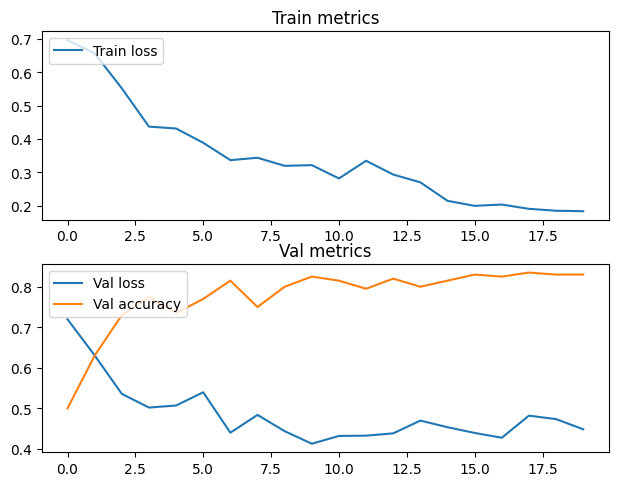

In [ ]:
ft_swin_face2face = DeepfakeClassifierSwin(finetuned=True).to(device)
if (os.path.exists('models/ft_swin/ft_swin_face2face.tar')):
    ft_swin_face2face.load_state_dict(torch.load('models/ft_swin/ft_swin_face2face.tar', weights_only=True))
else:
    train_model(ft_swin_face2face, face2face_train_dataloader, face2face_val_dataloader, 'ft_swin/ft_swin_face2face')

In [ ]:
ft_swin_face2face.eval()
mistakes = []  # first frames of videos that were misclassifed  
labels = []    # tuple for each frame: (predicted label, real label)
TP, TN, FP, FN = get_model_metrics(ft_swin_face2face, face2face_test_dataloader)

print(f'True Positive:  {TP}')
print(f'True Negative:  {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print('-----------------------')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN) * 100}%')

Testing: 100%|██████████| 7/7 [00:14<00:00,  2.14s/it]

True Positive:  91
True Negative:  86
False Positive: 14
False Negative: 9
-----------------------
Accuracy: 88.5%


#### FaceSwap

-------------------------------
Epoch 20 stats
Train loss: 0.1686
Validation accuracy: 0.9150
Validation loss: 0.2039
Current learning rate: 5e-05
-------------------------------


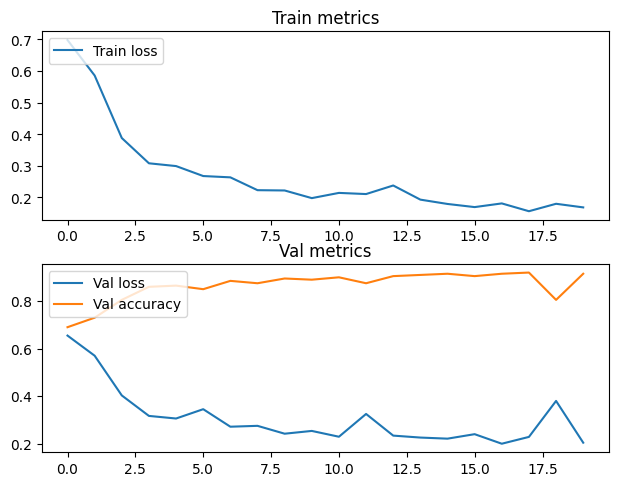

In [ ]:
ft_swin_faceswap = DeepfakeClassifierSwin(finetuned=True).to(device)
if (os.path.exists('models/ft_swin/ft_swin_faceswap.tar')):
    ft_swin_faceswap.load_state_dict(torch.load('models/ft_swin/ft_swin_faceswap.tar', weights_only=True))
else:
    train_model(ft_swin_faceswap, faceswap_train_dataloader, faceswap_val_dataloader, 'ft_swin/ft_swin_faceswap')

In [ ]:
ft_swin_faceswap.eval()
mistakes = []  # first frames of videos that were misclassifed  
labels = []    # tuple for each frame: (predicted label, real label)
TP, TN, FP, FN = get_model_metrics(ft_swin_faceswap, faceswap_test_dataloader)

print(f'True Positive:  {TP}')
print(f'True Negative:  {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print('-----------------------')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN) * 100}%')

Testing: 100%|██████████| 7/7 [00:15<00:00,  2.17s/it]

True Positive:  85
True Negative:  93
False Positive: 7
False Negative: 15
-----------------------
Accuracy: 89.0%
